In [3]:
from cycle_ratio import CycleRatio, read_graph, node_edge_count
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import time
import networkx as nx
from tqdm import tqdm
import json
import EoN
import random


cycle_ratio = {}
degree_ratio = {}
coreness_ratio = {}
h_index_ratio = {}

indices_performance = {}

datasets = ['Celegans.txt', 'Email.txt', 'Jazz.txt', 'NS_GC.txt', 'USAir.txt', 'Yeast.txt']

In [4]:
def hindex(g, n):
    sorted_neighbor_degrees = sorted(
        (g.degree(v) for v in g.neighbors(n)), reverse=True)
    h = 0
    for i in range(1, len(sorted_neighbor_degrees)+1):
        if sorted_neighbor_degrees[i-1] < i:
            break
        h = i
    return h


def node_importance_sorter(node_ratio: list):
    node_ratio = sorted(node_ratio, key=node_ratio.get, reverse=True)
    return node_ratio


def spreading(graph: nx.Graph, sorted_nodes: list, epoch: int=2000):
    rho = sorted_nodes[:int(len(sorted_nodes) * 0.1)]
    gamma = 1
    k = (2 * graph.number_of_edges())/graph.number_of_nodes()
    tau = k/((k**2)-k)
    timing = {
        "t1": [],
        "t2": [],
        "t4": [],
        "t8": [],
    }
    for _ in tqdm(range(epoch)):
        t1, S1, I1, R1 = EoN.Gillespie_SIR(graph, tau, gamma, tmax=9, initial_infecteds=rho)
        I1 = np.cumsum(I1)

        arr = np.array(t1)
        index = np.argmin(np.abs(arr - 1))
        timing['t1'].append(I1[index])

        index = np.argmin(np.abs(arr - 2))
        timing['t2'].append(I1[index])

        index = np.argmin(np.abs(arr - 4))
        timing['t4'].append(I1[index])

        index = np.argmin(np.abs(arr - 8))
        timing['t8'].append(I1[index])

    return {
        "t1": np.array(timing['t1']).mean(),
        "t2": np.array(timing['t2']).mean(),
        "t4": np.array(timing['t4']).mean(),
        "t8": np.array(timing['t8']).mean(),
    }

In [10]:
for index, network in enumerate(datasets):

    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = list(graph.nodes())

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    degree_ratio_data = nx.degree_centrality(graph)
    sorted_node_ratio = sorted(degree_ratio_data, key=degree_ratio_data.get, reverse=True)
    degree_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # H-index Ratio
    graph = read_graph(f'Dataset/{network}')

    h_index_ratio_data = {}
    for node in list(graph.nodes):
        sorted_neighbor_degrees = sorted(
            (graph.degree(v) for v in graph.neighbors(node)), reverse=True)
        h = 0
        for i in range(1, len(sorted_neighbor_degrees)+1):
            if sorted_neighbor_degrees[i-1] < i:
                break
            h = i
        h_index_ratio_data[node] = h

    sorted_node_ratio = node_importance_sorter(node_ratio=h_index_ratio_data)
    h_index_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # Coreness Ratio
    graph = read_graph(f'Dataset/{network}')
    coreness_ratio_data = nx.core_number(graph)
    sorted_node_ratio = node_importance_sorter(node_ratio=coreness_ratio_data)
    coreness_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # Cycle Ratio base node
    graph = read_graph(f'Dataset/{network}')
    cr = CycleRatio(graph=graph)
    cr.prune_graph()
    cr.getSmallestCycles()
    cr.StatisticsAndCalculateIndicators(network=network_name)
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = node_importance_sorter(node_ratio=cr.CycleRatio)
    cycle_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    indices_performance[network_name] = {
        'D': degree_spreding,
        'H': h_index_spreding,
        'C': coreness_spreding,
        'R': cycle_spreding,
    }

Processing Celegans network


100%|██████████| 2000/2000 [00:05<00:00, 394.18it/s]


Processing Email network


100%|██████████| 2000/2000 [00:14<00:00, 138.48it/s]


Processing Jazz network


100%|██████████| 2000/2000 [00:04<00:00, 403.71it/s]


Processing NS_GC network


100%|██████████| 2000/2000 [00:02<00:00, 713.29it/s]


Processing USAir network


100%|██████████| 2000/2000 [00:04<00:00, 406.83it/s]


Processing Yeast network


100%|██████████| 2000/2000 [00:32<00:00, 61.48it/s]


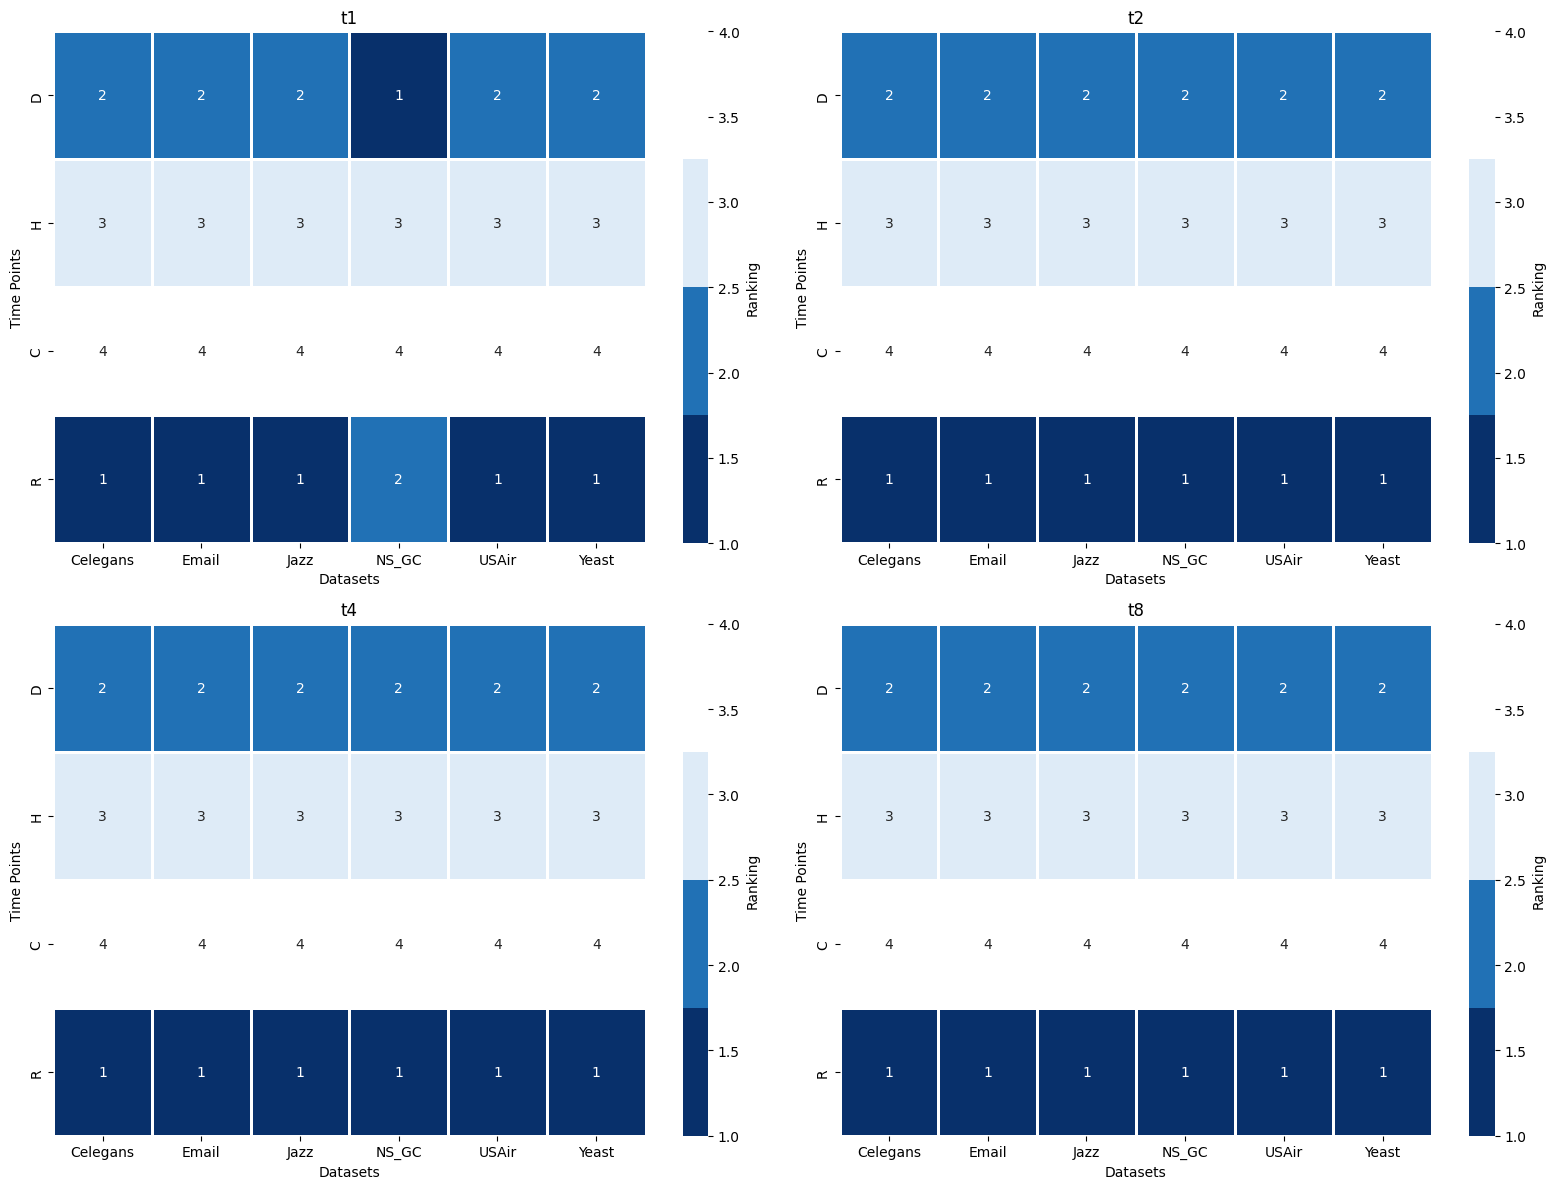

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, time in enumerate(['t1', 't2', 't4', 't8']):
    current_window = {}
    for key, value in indices_performance.items():
        current_window[key] = {}
        current_window[key]['D'] = indices_performance[key]['D'][time]
        current_window[key]['H'] = indices_performance[key]['H'][time]
        current_window[key]['C'] = indices_performance[key]['C'][time]
        current_window[key]['R'] = indices_performance[key]['R'][time]

    df = pd.DataFrame(current_window)
    ranked_df = df.rank(ascending=False)
    colors = ['#08306b', '#2171b5', '#deebf7', '#ffffff']
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=4)

    sns.heatmap(ranked_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Ranking'},
                linewidths=1, linecolor='white', vmin=1, vmax=4, ax=axes[i])
    
    axes[i].set_title(time)
    axes[i].set_xlabel('Datasets')
    axes[i].set_ylabel('Time Points')

plt.tight_layout()
plt.savefig(f'epidemic_spreading.jpg')
plt.show()

In [5]:
for index, network in enumerate(datasets):

    network_name = network.split('.')[0]
    print(f'Processing {network_name} network')

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = list(graph.nodes())
    random.shuffle(sorted_node_ratio)
    random_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # Degree Ratio
    graph = read_graph(f'Dataset/{network}')
    degree_ratio_data = nx.degree_centrality(graph)
    sorted_node_ratio = sorted(degree_ratio_data, key=degree_ratio_data.get, reverse=True)
    degree_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # H-index Ratio
    graph = read_graph(f'Dataset/{network}')

    h_index_ratio_data = {}
    for node in list(graph.nodes):
        sorted_neighbor_degrees = sorted(
            (graph.degree(v) for v in graph.neighbors(node)), reverse=True)
        h = 0
        for i in range(1, len(sorted_neighbor_degrees)+1):
            if sorted_neighbor_degrees[i-1] < i:
                break
            h = i
        h_index_ratio_data[node] = h

    sorted_node_ratio = node_importance_sorter(node_ratio=h_index_ratio_data)
    h_index_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # Coreness Ratio
    graph = read_graph(f'Dataset/{network}')
    coreness_ratio_data = nx.core_number(graph)
    sorted_node_ratio = node_importance_sorter(node_ratio=coreness_ratio_data)
    coreness_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    # Cycle Ratio base node
    graph = read_graph(f'Dataset/{network}')
    cr = CycleRatio(graph=graph)
    cr.prune_graph()
    cr.getSmallestCycles()
    cr.StatisticsAndCalculateIndicators(network=network_name)
    graph = read_graph(f'Dataset/{network}')
    sorted_node_ratio = node_importance_sorter(node_ratio=cr.CycleRatio)
    cycle_spreding = spreading(graph=graph, sorted_nodes=sorted_node_ratio, epoch=2000)

    indices_performance[network_name] = {
        'B': random_spreding,
        'D': degree_spreding,
        'H': h_index_spreding,
        'C': coreness_spreding,
        'R': cycle_spreding,
    }

Processing Celegans network


100%|██████████| 2000/2000 [00:04<00:00, 450.11it/s]


Processing Email network


100%|██████████| 2000/2000 [00:14<00:00, 135.47it/s]


Processing Jazz network


100%|██████████| 2000/2000 [00:04<00:00, 441.74it/s]


Processing NS_GC network


100%|██████████| 2000/2000 [00:02<00:00, 675.19it/s]


Processing USAir network


100%|██████████| 2000/2000 [00:04<00:00, 421.55it/s]


Processing Yeast network


100%|██████████| 2000/2000 [00:32<00:00, 62.43it/s]


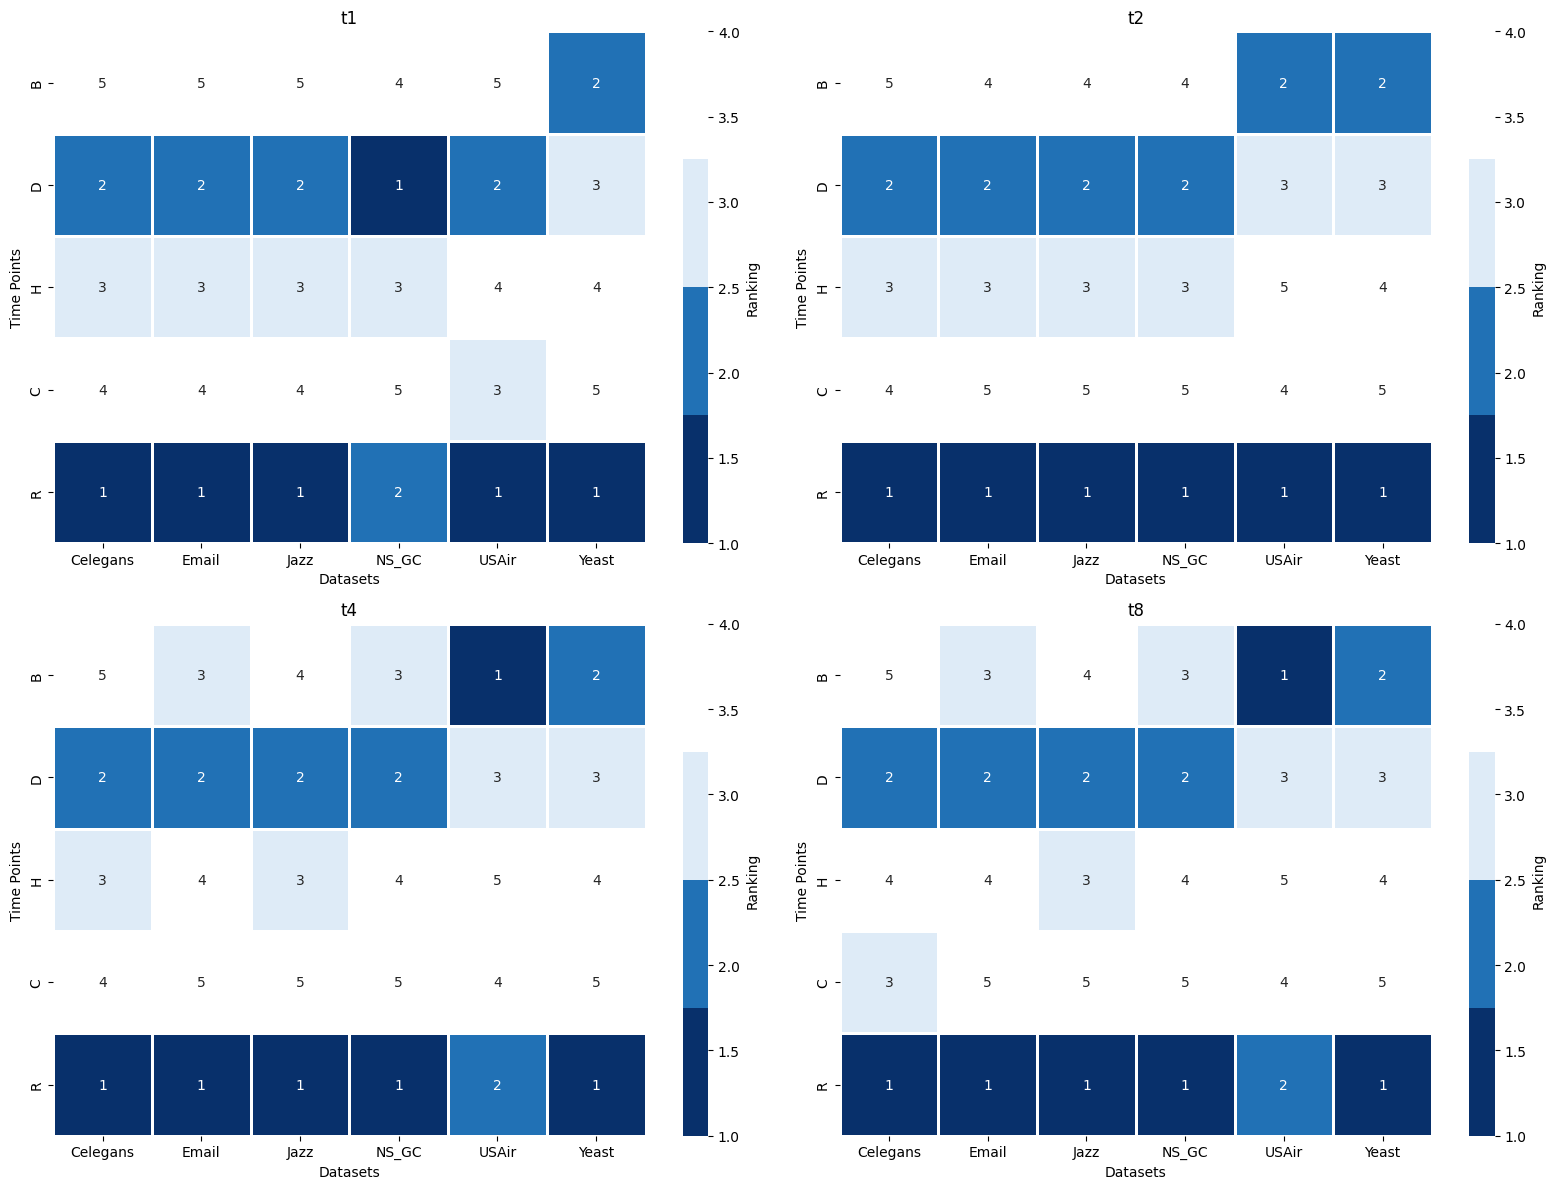

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, time in enumerate(['t1', 't2', 't4', 't8']):
    current_window = {}
    for key, value in indices_performance.items():
        current_window[key] = {}
        current_window[key]['B'] = indices_performance[key]['B'][time]
        current_window[key]['D'] = indices_performance[key]['D'][time]
        current_window[key]['H'] = indices_performance[key]['H'][time]
        current_window[key]['C'] = indices_performance[key]['C'][time]
        current_window[key]['R'] = indices_performance[key]['R'][time]

    df = pd.DataFrame(current_window)
    ranked_df = df.rank(ascending=False)
    colors = ['#08306b', '#2171b5', '#deebf7', '#ffffff']
    custom_cmap = LinearSegmentedColormap.from_list('custom_blue', colors, N=4)

    sns.heatmap(ranked_df, annot=True, cmap=custom_cmap, cbar_kws={'label': 'Ranking'},
                linewidths=1, linecolor='white', vmin=1, vmax=4, ax=axes[i])
    
    axes[i].set_title(time)
    axes[i].set_xlabel('Datasets')
    axes[i].set_ylabel('Time Points')

plt.tight_layout()
plt.savefig(f'epidemic_spreading_with_random.jpg')
plt.show()
